## Universidad del Valle de Guatemala
### Security Data Science
* Juan Marroquin 19845
* Carlos Raxtum 19721


##### Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, tree, model_selection, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import re
import pandas_profiling
%matplotlib inline

#### Load the dataset

In [92]:
df = pd.read_csv ('dataset_pishing.csv')

#### Show first 5 rows

In [93]:
df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [94]:
df.columns.values

array(['url', 'ip', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path',
       'punycode', 'port', 'tld_in_path', 'tld_in_subdomain',
       'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix',
       'random_domain', 'shortening_service', 'path_extension',
       'nb_redirection', 'nb_external_redirection', 'length_words_raw',
       'char_repeat', 'shortest_words_raw', 'shortest_word_host',
       'shortest_word_path', 'longest_words_raw', 'longest_word_host',
       'longest_word_path', 'avg_words_raw', 'avg_word_host',
       'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS',
       'ratio_intRedirection', 'ratio_extRedirection', 'ratio_intErrors',
       'ratio_extErrors', 'login_form', 'external_favicon',
       'links_in_tags', 'submit_email', 'ratio_intMedia',
       'ratio_extMedi

#### Show the count of observations in the status columns

In [95]:
df['status'].value_counts()

legitimate    5715
phishing      5715
Name: status, dtype: int64

Se puede observar que el dataset esta balanceado ya que hay la misma cantidad de urls catalogadas como pshing como legitimate

Derivación de características
En base al artículo “Towards Benchmark Datasets for ML Based Wensite Phishing Detection: An
Experimental Study”, derivar las características basadas en el dominio: f1, f2, f4 – f20, f25, f26 y f27.
Para ello escriba las funciones necesarias y genere las nuevas columnas del dataset. Muestre un nuevo
ejemplo de cinco observaciones donde se visualicen algunas de las columnas nuevas

#### En base al artículo “Towards Benchmark Datasets for ML Based Wensite Phishing Detection: An Experimental Study” se derivan:

1. f1 = Full URL length
2. f2 = Hostname length
3. f4 -> f20 = Number of occurrences of the following characters: ’.’ (f4), ’-’ (f5), ’@’ (f6) , ’?’ (f7), ’&’ (f8), ’|’ (f9), ’=’ (f10), ’_’ (f11), ’ ̃’ (f12), ’%’ (f13), ’/’ (f14), ’*’ (f15), ’:’ (f16), ’,’ (f17), ’;’ (f18), '$'(f19), ’%20’ or space (f20)
4. f25 = HTTPS token
5. f26 = Ratio of digits in full URLs
6. f27 = Ratio of digits in hostnames

#### F1 y F2

Las URL largas se utilizan para ocultar dominios y subdominios reales. Consideramos: lleno
Longitud de URL (f1) y longitud de nombre de host (f2).

In [96]:
# f1
df['url_len'] = df['url'].apply(len)

In [97]:
# f2
from urllib.parse import urlparse

def url_info(url):
    parsed_url = urlparse(url)
    return parsed_url.hostname, parsed_url.scheme

df['hostname'], df['scheme'] = zip(*df['url'].apply(url_info)) # scheme for f25
df['hostname_len'] = df['hostname'].apply(len)

#### f4 - f20

Los caracteres especiales se utilizan para engañar a los usuarios novatos de dominios y subdominios reales.
red eléctrica. Consideramos el número de ocurrencias de los siguientes caracteres: '.'
(f4), '-' (f5), '@' (f6), '?' (f7), '&' (f8), '|' (f9), '=' (f10), '_' ( f11), ' ̃' (f12),
'%' (f13), '/' (f14), '*' (f15), ':' (f16), ',' (f17), ';' (f18), '$' (f19), ' %20' o
espacio (f20).

In [98]:
#f4 - f20
chars = ['.','-','@','?','&','|','=','_',' ̃','%','/','*',':',',',';','$']
spaces = ['%20', ' '] # two options for spaces

def count_chars(chs):
    return lambda s: sum(s.count(ch) for ch in chs)

for ch in chars:
    df[f'{ch}_count'] = df['url'].apply(count_chars(ch))

df['space_count'] = df['url'].apply(count_chars(spaces))

#### f25

La mayoría de los sitios web de phishing no brindan ningún servicio de seguridad en comparación con
los legítimos. Por lo tanto, el uso de HTTPS es un indicador de legitimidad.

In [99]:
# f25
df['is_https'] = df['scheme'].apply(lambda scheme: int(scheme.lower() == 'https'))

#### f26 -f27

Un alto número de dígitos en las URL se considera un indicador de phishing. Nosotros
considere la proporción de dígitos en las URL completas (f26) y los nombres de host (f27).

In [100]:
#f26
digits_ratio = lambda s: sum(c.isdigit() for c in s) / sum(not c.isdigit() for c in s)
df['digit_ratio_url'] = df['url'].apply(digits_ratio)


In [101]:
# f27
df['digit_ratio_hostname'] = df['url'].apply(digits_ratio)

In [102]:
# Drop added columns no longer needed
df = df.drop(['hostname', 'scheme'], axis=1)

#### Show first 5 rows after transformations

In [103]:
df.head()

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,/_count,*_count,:_count,",_count",;_count,$_count,space_count,is_https,digit_ratio_url,digit_ratio_hostname
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,3,0,1,0,0,0,0,0,0.000000,0.000000
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,5,0,1,0,0,0,0,0,0.283333,0.283333
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,5,0,1,0,0,0,0,1,0.177570,0.177570
3,http://rgipt.ac.in,0,0,0,0,0,0,0,0,0,...,2,0,1,0,0,0,0,0,0.000000,0.000000
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,5,0,1,0,0,0,0,0,0.000000,0.000000


#### Preprocessing the dataset

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   ip                          11430 non-null  int64  
 2   nb_www                      11430 non-null  int64  
 3   nb_com                      11430 non-null  int64  
 4   nb_dslash                   11430 non-null  int64  
 5   http_in_path                11430 non-null  int64  
 6   punycode                    11430 non-null  int64  
 7   port                        11430 non-null  int64  
 8   tld_in_path                 11430 non-null  int64  
 9   tld_in_subdomain            11430 non-null  int64  
 10  abnormal_subdomain          11430 non-null  int64  
 11  nb_subdomains               11430 non-null  int64  
 12  prefix_suffix               11430 non-null  int64  
 13  random_domain               114

In [105]:
# converting the status column to binariy
df['status'] = np.where(df['status'] == 'phishing', 1, 0)

In [106]:
df = df.drop(['url'], axis=1)

In [107]:
df.head(5)

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,/_count,*_count,:_count,",_count",;_count,$_count,space_count,is_https,digit_ratio_url,digit_ratio_hostname
0,0,1,0,0,0,0,0,0,0,0,...,3,0,1,0,0,0,0,0,0.000000,0.000000
1,1,0,0,0,0,0,0,0,0,0,...,5,0,1,0,0,0,0,0,0.283333,0.283333
2,1,0,1,0,0,0,0,0,1,0,...,5,0,1,0,0,0,0,1,0.177570,0.177570
3,0,0,0,0,0,0,0,0,0,0,...,2,0,1,0,0,0,0,0,0.000000,0.000000
4,0,1,0,0,0,0,0,0,0,0,...,5,0,1,0,0,0,0,0,0.000000,0.000000


#### Pandas Profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\melma\AppData\Roaming\Python\Python39\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
C:\Users\melma\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (66).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

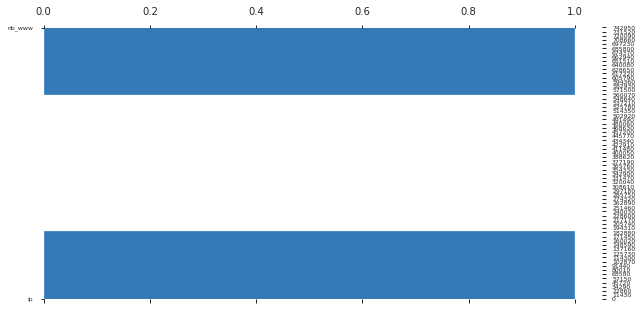

In [12]:
profile = df.profile_report(title="Phishing dataset Report")
profile.to_file(output_file="lab1_pandas_report.html")

#### Based on the report, drop the next columns

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ip                          11430 non-null  int64  
 1   nb_www                      11430 non-null  int64  
 2   nb_com                      11430 non-null  int64  
 3   nb_dslash                   11430 non-null  int64  
 4   http_in_path                11430 non-null  int64  
 5   punycode                    11430 non-null  int64  
 6   port                        11430 non-null  int64  
 7   tld_in_path                 11430 non-null  int64  
 8   tld_in_subdomain            11430 non-null  int64  
 9   abnormal_subdomain          11430 non-null  int64  
 10  nb_subdomains               11430 non-null  int64  
 11  prefix_suffix               11430 non-null  int64  
 12  random_domain               11430 non-null  int64  
 13  shortening_service          114

#### Seleccion de caracteristicas

Selección de Características
En base al reporte generado, las características relevantes que se relacionan con [status] que pudimos identificar son:

- status
- nb_www
- phish_hints
- nb_hyperlinks
- length_words_raw
- domain_in_title
- ratio_intHyperlinks
- ratio_extHyperlinks
- domain_age
- web_traffic
- page_rank
- url_len
- hostname_len
- space_count
- digit_ratio_url

In [108]:
# limpiar el dataset para dejar solo las caracteristicas necesarias para el modelo
clean_df = df[['status','nb_www', 'phish_hints', 'nb_hyperlinks', 'length_words_raw', 'domain_in_title', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'domain_age', 'web_traffic', 'page_rank', 'url_len', 'hostname_len', 'space_count', 'digit_ratio_url']]


In [109]:
# Verifique que no posee datos repetidos

clean_df.drop_duplicates()

,status,nb_www,phish_hints,nb_hyperlinks,length_words_raw,domain_in_title,ratio_intHyperlinks,ratio_extHyperlinks,domain_age,web_traffic,page_rank,url_len,hostname_len,space_count,digit_ratio_url
0,0,1,0,17,4,0,0.529412,0.470588,-1,0,4,37,19,0,0.000000
1,1,0,0,30,4,1,0.966667,0.033333,5767,0,2,77,23,0,0.283333
2,1,0,0,4,12,1,1.000000,0.000000,4004,5828815,0,126,50,0,0.177570
3,0,0,0,149,1,1,0.973154,0.026846,-1,107721,3,18,11,0,0.000000
4,0,1,0,102,6,0,0.470588,0.529412,8175,8725,6,55,15,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,1,0,199,4,0,0.884422,0.115578,5396,3980,6,45,17,0,0.000000
11426,1,1,0,3,12,1,1.000000,0.000000,6728,0,0,84,18,1,0.024390
11427,0,1,0,68,13,0,0.470588,0.529412,8515,8,10,105,16,0,0.166667
11428,0,1,0,32,2,1,0.375000,0.625000,2836,2455493,4,38,30,0,0.000000


### Parte 2

#### Create the train,test and validation 
* train size 55%
* test size 30%
* validation size 15%

In [110]:
train_size=0.55
test_size = 0.66 # this is equavalent to the 30% of the test size

In [111]:
X = df.drop(columns = ['status']).copy()
y = df['status']

In [112]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=train_size,random_state=42)

In [113]:
# Now since we want the valid and test size. 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size,random_state=42)

#### Saving the train, test and validation data sets

In [114]:
train_df = X_train.copy()
train_df['status'] = y_train.tolist()
train_df.reset_index(drop=True, inplace=True)
train_df.to_csv('train_dataset.csv', index = False, encoding='utf-8')

In [115]:
valid_df = X_valid.copy()
valid_df['status'] = y_valid.tolist()
valid_df.reset_index(drop=True, inplace=True)
valid_df.to_csv('validation_dataset.csv', index = False, encoding='utf-8')

In [116]:
test_df = X_test.copy()
test_df['status'] = y_test.tolist()
test_df.reset_index(drop=True, inplace=True)
test_df.to_csv('test_dataset.csv', index = False, encoding='utf-8')

#### Machine Learning Implamentation

Utilice dos algoritmos de Machine Learning para entrenar el modelo. Muestre y explique los valores obtenidos de las siguientes métricas para los datos de validación y pruebas, para cada modelo, en base al contexto del problema (detección de Pishing).
* Matriz de confusión
* Precision
* Recall
* F1 Score

#### Creación del modelo

In [117]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score

In [118]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [119]:
# Entrenamos el modelo
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

Utilizamos el clasificador de bosque aleatorio.

que es un bosque aleatorio, un metaestimador que ajusta una serie de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. 

Los valores predeterminados para los parámetros que controlan el tamaño de los árboles conducen a árboles completamente desarrollados y sin podar que pueden ser potencialmente muy grandes en algunos conjuntos de datos. Para reducir el consumo de memoria, la complejidad y el tamaño de los árboles deben controlarse configurando esos valores de parámetros.

#### Validación

In [120]:
# Realizamos predicciones con las metricas de validación
predictions = rf.predict(X_valid)

# Get the results y_valid
validation_confusion_matrix = confusion_matrix(y_valid, predictions)
validation_recall_score = recall_score(y_valid, predictions, average=None)
validation_precision_score = precision_score(y_valid, predictions, average=None)
validation_f1_score = f1_score(y_valid, predictions, average=None)
print("Matrix de confusión: ", validation_confusion_matrix)


Matrix de confusión:  [[841  30]
 [ 27 850]]


In [121]:
print(classification_report(y_valid, predictions, target_names = ["legit", "dga"]))
print("recall_score: ",recall_score)
print("precision_score: ", precision_score)
print("f1_score: ", f1_score)
print("accuracy: ", accuracy_score(y_valid, predictions))

              precision    recall  f1-score   support

       legit       0.97      0.97      0.97       871
         dga       0.97      0.97      0.97       877

    accuracy                           0.97      1748
   macro avg       0.97      0.97      0.97      1748
weighted avg       0.97      0.97      0.97      1748

recall_score:  <function recall_score at 0x00000164A8B6F310>
precision_score:  <function precision_score at 0x00000164A8B6F280>
f1_score:  <function f1_score at 0x00000164A8B67EE0>
accuracy:  0.967391304347826


En base a los resultados, podemos observar que en general todos nuestros valores van rondando al rededor de 0.96 con ello  procederemos a seguir con nuestro test set ya que los resultdis de esta primera validacion nos lo permite

#### Predicciones finales

In [122]:
predictions = rf.predict(X_test)

In [123]:
y_test.shape

(3396,)

In [124]:
predictions.shape

(3396,)

In [125]:
_confusion_matrix = confusion_matrix(y_test, predictions)
_recall_score = recall_score(y_test, predictions, average=None)
_precision_score = precision_score(y_test, predictions, average=None)
_f1_score = f1_score(y_test, predictions, average=None)

In [126]:
print("Matrix de confusión")
_confusion_matrix

Matrix de confusión


array([[1635,   61],
       [  73, 1627]], dtype=int64)

In [127]:
classification_report(y_test, predictions, target_names = ["legit", "dga"])

'              precision    recall  f1-score   support\n\n       legit       0.96      0.96      0.96      1696\n         dga       0.96      0.96      0.96      1700\n\n    accuracy                           0.96      3396\n   macro avg       0.96      0.96      0.96      3396\nweighted avg       0.96      0.96      0.96      3396\n'

In [128]:
print("recall_score")
_recall_score

recall_score


array([0.96403302, 0.95705882])

In [129]:
print("precision_score")
_precision_score

precision_score


array([0.95725995, 0.96386256])

In [130]:
print("f1_score")
_f1_score

f1_score


array([0.96063455, 0.96044864])

In [131]:
print("Accuracy")
accuracy_score(y_test, predictions)

Accuracy


0.9605418138987044

#### Discusion

#### 1. ¿Cuál es el impacto de clasificar un sitio legítimo como Pishing?
- Seria un problema y realmente dependeria el caso sobre que tan grave puede ser, por ejemplo si es un sitio de una empresa de alto prestigio pues corre el riesgo a afectar la confianza de sus clientes, puede afectar en el trafico en el sitio, lo cual puede representar perdidas para la compañia.

#### 2. ¿Cuál es el impacto de clasificar un sitio de Pishing como legítimo?
- esto podria tener un impacto negativo debido a que que podria volnerar la seguridad de una organizacion, robos de informacion entre otros.

#### 3. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de pishing?
- En base a nuestro analisis, consideramos  que el recall es la mejor métrica para este problema, debido a que nos indica la habilidad del modelo de encontrar los positivos.

#### 4. ¿Qué modelo es mejor para la clasificación de Pishing? Justifique
- En base a lo trabajado en este laboratorio podriamos indicar que el RandomForestClassifier es bastante efectipo 

#### 5. En base a las métricas obtenidas ¿es necesaria la intervención de una persona humana para tomar la decisión final?
- Consideramos que no deberia ser necesaria debido a que ya existen metricas suficientes como para crear un modelo automatizado que permita detectar sitio de phising
